In [3]:
from qwak.qwak import QWAK
from utils.plotTools import searchProbStepsPlotting,searchProbStepsPlotting2

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
import math
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk
from qwak.ProbabilityDistribution import ProbabilityDistribution
from qwak.qwak import QWAK
import copy
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.ndimage import gaussian_filter


In [4]:
def smooth_matrices(matrix1, matrix2, matrix3, sigma=1):
    """
    Applies 2D Gaussian smoothing to three input matrices.
    
    Parameters:
        matrix1 (numpy array): first input matrix
        matrix2 (numpy array): second input matrix
        matrix3 (numpy array): third input matrix
        sigma (float): standard deviation of the Gaussian filter
    
    Returns:
        tuple: a tuple of three smoothed matrices
    """
    smoothed_matrix1 = gaussian_filter(matrix1, sigma=sigma)
    smoothed_matrix2 = gaussian_filter(matrix2, sigma=sigma)
    smoothed_matrix3 = gaussian_filter(matrix3, sigma=sigma)
    
    return (smoothed_matrix1, smoothed_matrix2, smoothed_matrix3)

def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def plotSearch(N,probT,tSpace,configVec):
    plotName = ""
    for T,walk,config,n in zip(tSpace,probT,configVec,N):
        #print(config)
        plt.plot(T,walk,color=config[0],linestyle=config[1],label="N=%s"%n)
        plt.vlines(max(T),0,1,color=config[0],linestyle=config[2])
        plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for n in N:
        plotName+='_'+str(n)
    plt.savefig(r"C:\Users\jaime\Documents\GitHub\QWAK\Notebook\Output\\"+f"Search{plotName}")
    # plt.clf()
    
def plotSearch2(markedList, probT, tSpace, configVec,labels):
    %matplotlib inline
    plotName = ""
    fig = plt.figure()
    for T, walk, config, marked, label in zip(tSpace, probT, configVec, markedList,labels):
        plt.plot(T, walk, color=config[0], linestyle=config[1], label=label)
        # plt.vlines(max(T), 0, max(probT[0]), color=config[0], linestyle=config[2])
        #plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for marked in markedList:
        plotName += '_' + str(len(marked))
    return fig

def gamma_hypercube(n):
    total = 0
    for r in range(1, n + 1):
        binomial_coefficient = math.comb(n, r)
        total += binomial_coefficient * (1 / r)
    return ((1 / (2 ** n)) * total)/2

In [5]:
n=10
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n) # Gamma do paper do renato https://arxiv.org/pdf/2212.08889.pdf

N = len(graph)
markedElements = [(N//2,-1)]

t = np.floor(np.pi/2 * sqrt(N)) 
initCond = list(range(0,len(graph)))


qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
qw.runWalk(time=t,initStateList=initCond)
# plt.plot(qw.getProbVec())

N = 64


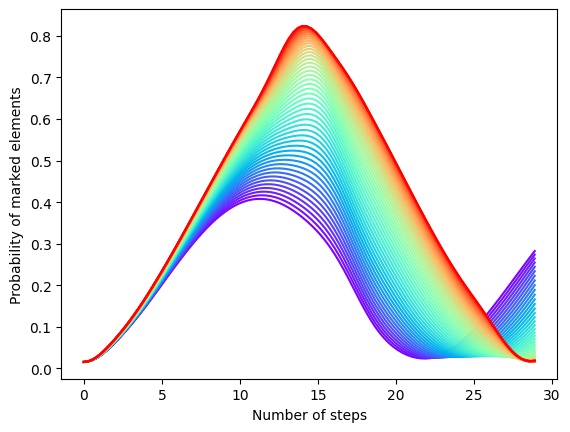

In [20]:
def modify_marked_prob_list(marked_prob_list):
    modified_list = []
    for sublist in marked_prob_list:
        new_sublist = sublist.copy()

        max_idx = new_sublist.index(max(new_sublist))
        min_found = False
        last_min_value = None

        for idx, elem in enumerate(new_sublist[max_idx:]):
            if idx + max_idx > 0 and new_sublist[idx + max_idx - 1] > elem:
                min_found = True
                last_min_value = elem
            if min_found and new_sublist[idx + max_idx - 1] < elem:
                new_sublist[idx + max_idx:] = [last_min_value] * len(new_sublist[idx + max_idx:])
                break

        modified_list.append(new_sublist)
    return modified_list

def plotSearch2(markedList, probT, tSpace, configVec,labels):
    plotName = ""
    fig = plt.figure()
    for T, walk, config, marked, label in zip(tSpace, probT, configVec, markedList,labels):
        plt.plot(T, walk, color=config[0], linestyle=config[1], label=label)
        # plt.vlines(max(T), 0, max(probT[0]), color=config[0], linestyle=config[2])
        #plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for marked in markedList:
        plotName += '_' + str(len(marked))
    return fig

n=6
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n)

N = len(graph)
print(f'N = {N}')
initCond = list(range(0,len(graph)))
t =  (np.pi/(2) * np.sqrt(N)) 

timeList = np.linspace(0,2.3*t,100)
gammaList =  np.linspace(gamma/1.3,gamma ,50).tolist() #[gamma]
# print(f'gammaList = {gammaList} \n gamma = {gamma}' )
markedProbList = []
markedSearch = []
timeListList = []
labelList = []
probDistList = []

colors = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))
lines = ['-']*len(gammaList)
lines2 = ['--']*len(gammaList)
configVec = zip(colors,lines,lines2)

for gamma in gammaList:
    qw = QWAK(graph=graph,gamma=gamma,markedElements=[(N//2,-1)],laplacian=False)
    for time in timeList:
        qw.runWalk(time=time,initStateList=initCond)
        probDistList.append(copy.deepcopy(qw.getProbDist()))
    markedProbList.append(searchProbStepsPlotting2(qw,probDistList))
    probDistList = []
    markedSearch.append( [(N//2,-1)])
    timeListList.append( timeList)
    labelList.append(f'{round(gamma,7)}')
    qw.resetWalk()


# Modify the markedProbList using the function
modified_marked_prob_list = modify_marked_prob_list(markedProbList)
plotAux = []
plotS = plotSearch2(markedSearch,markedProbList,timeListList,configVec,labelList)
plt.show()